# Nathaniel Callabresi Assignment 1

**Course:** GenAI for Software Development (CSCI 455/555)  
**Date:** February 18,2026  
**Instructor:** Dr. Antonio Mastropaolo  
**TA:** Md. Zahidul Haque Alvi

---

## Objective

In this notebook, we create a dataset of **tokenized Java methods** for training N-gram language models on code completion. We then train and evaluate the Lidstone N-gram models (N = 3, 5, 7) to find the best one. We then test the best model on the self made and provided test sets.

### Project Overview
1. Clone repositories from GitHub (>4000 stars, not forks)
2. Select Java files (20 classes per repo)
3. Parse and extract methods
4. Filter methods (non-ASCII, minimum 10 tokens, maximum 512 tokens, minimum 10 unique tokens)
5. Tokenize (space-separated)
6. Clean (remove incomplete methods, multi-method lines)
7. Deduplicate (remove exact duplicates across dataset)
8. Split and save into train/val/test for minilab 1 requirements
9. Plot cyclomatic complexity
10. Summarize dataset statistics (Marks the end of the minilab 1)
11. Combine the minilab 1 dataset and split into train/val/test for assignment 1 requirements
12. Train 3 Lidstone N-gram models (N = 3, 5, 7) for each training set
13. Evaluate the 9 N-gram models to find the best one
14. Test the best model on the self made and provided test sets

---
## Cell 1: Setup & Imports

In [1]:
# Install required packages
!pip install javalang gitpython pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 4.5 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 3.0 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import os
import glob
import subprocess
import json
import random
import shutil
from pathlib import Path

import pandas as pd
import javalang
from javalang.tokenizer import tokenize

# Path configuration
CLONE_DIR = "dataset/java_repos"
OUTPUT_DIR = "dataset/ngram_dataset"

CLASSES_PER_REPO = 20   # Java files to sample per repo
MIN_TOKENS = 10         # Minimum tokens per method
MAX_TOKENS = 512        # Maximum tokens per method
MIN_UNIQUE_TOKENS = 10  # Minimum unique tokens per method

VAL_SIZE = 1000
TEST_SIZE = 1000

# Create directories
os.makedirs(CLONE_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Setup complete!")
print(f"Clone directory: {CLONE_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

Setup complete!
Clone directory: dataset/java_repos
Output directory: dataset/ngram_dataset


---
## Fetch Repository List

We fetch top Java repositories from GitHub API with the following filters:

- **Language:** Java
- **Stars:** >4000 (to ensure high-quality, well-maintained projects)
- **Forks:** excluded (to avoid duplicate code)

We exclude forked repositories to avoid code duplication, as done in [Tufano et al., 2024](https://arxiv.org/pdf/2402.16480). We use a higher star threshold (>4000 vs >10 in that paper) since our goal is to create quality training data, not to maximize repository coverage.

In [ ]:
import requests

def fetch_top_java_repos(num_repos=200, per_page=100):
    """
    Fetch top-starred Java repositories from GitHub API.
    Skips forked repos to avoid duplicate code.
    """
    repos = []
    page = 1

    while len(repos) < num_repos:
        url = "https://api.github.com/search/repositories"
        params = {
            # Used https://seart-ghs.si.usi.ch/ to make sure it would have over 700 results
            "q": "language:java stars:>4000",
            "sort": "stars",
            "order": "desc",
            "per_page": per_page,
            "page": page
        }

        response = requests.get(url, params=params)

        if response.status_code != 200:
            print(f"Error: {response.status_code}")
            break

        data = response.json()
        items = data.get("items", [])

        if not items:
            break

        for item in items:
            if item.get("fork", False):
                continue

            repos.append({
                "full_name": item["full_name"],
                "clone_url": item["clone_url"],
                "stars": item["stargazers_count"],
                "description": item.get("description", "")
            })

        page += 1

        if len(repos) >= num_repos:
            break

    return repos[:num_repos]

# Fetch repositories
print("Fetching top Java repositories from GitHub...")
repo_data = fetch_top_java_repos(num_repos=700)
df_repos = pd.DataFrame(repo_data)

print(f"\nFetched {len(df_repos)} repositories")
print(f"\nTop 10 repos by stars:")
df_repos.head(10)

Fetching top Java repositories from GitHub...

Fetched 700 repositories

Top 10 repos by stars:


,full_name,clone_url,stars,description
0,Snailclimb/JavaGuide,https://github.com/Snailclimb/JavaGuide.git,153745,Java 面试 & 后端通用面试指南，覆盖计算机基础、数据库、分布式、高并发与系统设计。准备...
1,krahets/hello-algo,https://github.com/krahets/hello-algo.git,122133,《Hello 算法》：动画图解、一键运行的数据结构与算法教程。支持简中、繁中、English...
2,GrowingGit/GitHub-Chinese-Top-Charts,https://github.com/GrowingGit/GitHub-Chinese-T...,106017,:cn: GitHub中文排行榜，各语言分设「软件 | 资料」榜单，精准定位中文好项目。各取...
3,iluwatar/java-design-patterns,https://github.com/iluwatar/java-design-patter...,93690,Design patterns implemented in Java
4,macrozheng/mall,https://github.com/macrozheng/mall.git,82866,mall项目是一套电商系统，包括前台商城系统及后台管理系统，基于Spring Boot+My...
5,spring-projects/spring-boot,https://github.com/spring-projects/spring-boot...,79847,Spring Boot helps you to create Spring-powered...
6,doocs/advanced-java,https://github.com/doocs/advanced-java.git,78817,😮 Core Interview Questions & Answers For Exper...
7,MisterBooo/LeetCodeAnimation,https://github.com/MisterBooo/LeetCodeAnimatio...,76703,Demonstrate all the questions on LeetCode in t...
8,elastic/elasticsearch,https://github.com/elastic/elasticsearch.git,76019,"Free and Open Source, Distributed, RESTful Sea..."
9,TheAlgorithms/Java,https://github.com/TheAlgorithms/Java.git,64950,All Algorithms implemented in Java


---
## Clone Repositories

We clone each repository using `--depth 1` (shallow clone) since we only need the current code snapshot, not the full commit history. This saves time and disk space.

In [9]:
def clone_repo(clone_url, dest_dir):
    """
    Shallow clone a repository.
    Returns True if successful, False otherwise.
    """
    try:
        if os.path.exists(dest_dir):
            shutil.rmtree(dest_dir)

        cmd = ["git", "clone", "--depth", "1", "--quiet", clone_url, dest_dir]
        result = subprocess.run(cmd, capture_output=True, text=True, timeout=120)

        return result.returncode == 0
    except subprocess.TimeoutExpired:
        print(f"  Timeout cloning {clone_url}")
        return False
    except Exception as e:
        print(f"  Error: {e}")
        return False


# Clone repositories
cloned_repos = []
failed_repos = []

print(f"Cloning {len(df_repos)} repositories...\n")

for idx, row in df_repos.iterrows():
    repo_name = row["full_name"]
    clone_url = row["clone_url"]

    safe_name = repo_name.replace("/", "_")
    dest_dir = os.path.join(CLONE_DIR, safe_name)

    print(f"[{idx+1}/{len(df_repos)}] Cloning {repo_name}...", end=" ")

    success = clone_repo(clone_url, dest_dir)

    if success:
        cloned_repos.append({
            "repo_name": repo_name,
            "local_path": dest_dir,
            "stars": row["stars"]
        })
        print("done")
    else:
        failed_repos.append(repo_name)
        print("failed")

print(f"\n\nSummary:")
print(f"  Successfully cloned: {len(cloned_repos)}")
print(f"  Failed: {len(failed_repos)}")

Cloning 700 repositories...

[1/700] Cloning Snailclimb/JavaGuide... done
[2/700] Cloning krahets/hello-algo... done
[3/700] Cloning GrowingGit/GitHub-Chinese-Top-Charts... done
[4/700] Cloning iluwatar/java-design-patterns... done
[5/700] Cloning macrozheng/mall... done
[6/700] Cloning spring-projects/spring-boot... done
[7/700] Cloning doocs/advanced-java... done
[8/700] Cloning MisterBooo/LeetCodeAnimation... done
[9/700] Cloning elastic/elasticsearch... done
[10/700] Cloning TheAlgorithms/Java... done
[11/700] Cloning kdn251/interviews... done
[12/700] Cloning NationalSecurityAgency/ghidra... done
[13/700] Cloning spring-projects/spring-framework... done
[14/700] Cloning google/guava... done
[15/700] Cloning termux/termux-app... done
[16/700] Cloning dbeaver/dbeaver... done
[17/700] Cloning ReactiveX/RxJava... done
[18/700] Cloning skylot/jadx... done
[19/700] Cloning jeecgboot/JeecgBoot... done
[20/700] Cloning apache/dubbo... done
[21/700] Cloning PhilJay/MPAndroidChart... done
[

---
## Find and Select Java Files

For each cloned repository, we:
1. Find all `.java` files (excluding test/example directories)
2. Randomly select up to 20 files per repo
3. Track which files were used (so students can build test sets from remaining files)

In [10]:
def find_java_files(repo_path):
    """
    Find all .java files in a repository.
    Excludes test files and common non-source directories.
    """
    java_files = []
    exclude_patterns = ["test", "tests", "example", "examples", "sample", "demo", "generated"]

    for root, dirs, files in os.walk(repo_path):
        root_lower = root.lower()
        if any(pattern in root_lower for pattern in exclude_patterns):
            continue

        for file in files:
            if file.endswith(".java"):
                java_files.append(os.path.join(root, file))

    return java_files


def select_java_files(java_files, max_files):
    """
    Randomly select up to max_files from the list.
    """
    if len(java_files) <= max_files:
        return java_files
    return random.sample(java_files, max_files)


# Find and select Java files from each repo
repo_java_files = {}
all_selected_files = []

print(f"Finding Java files (selecting up to {CLASSES_PER_REPO} per repo)...\n")

for repo_info in cloned_repos:
    repo_name = repo_info["repo_name"]
    repo_path = repo_info["local_path"]

    java_files = find_java_files(repo_path)

    if not java_files:
        print(f"  {repo_name}: No Java files found")
        continue

    selected = select_java_files(java_files, max_files=CLASSES_PER_REPO)

    repo_java_files[repo_name] = {
        "total_files": len(java_files),
        "selected_files": [os.path.relpath(f, repo_path) for f in selected],
        "remaining_files": len(java_files) - len(selected)
    }

    all_selected_files.extend([(repo_name, f) for f in selected])
    print(f"  {repo_name}: {len(selected)}/{len(java_files)} files selected")

print(f"\nTotal Java files selected: {len(all_selected_files)}")

Finding Java files (selecting up to 20 per repo)...

  Snailclimb/JavaGuide: 1/1 files selected
  krahets/hello-algo: 20/340 files selected
  GrowingGit/GitHub-Chinese-Top-Charts: 1/1 files selected
  iluwatar/java-design-patterns: 20/1233 files selected
  macrozheng/mall: 20/508 files selected
  spring-projects/spring-boot: 20/3720 files selected
  doocs/advanced-java: 1/1 files selected
  MisterBooo/LeetCodeAnimation: 11/11 files selected
  elastic/elasticsearch: 20/13905 files selected
  TheAlgorithms/Java: 20/786 files selected
  kdn251/interviews: 20/515 files selected
  NationalSecurityAgency/ghidra: 20/13251 files selected
  spring-projects/spring-framework: 20/4927 files selected
  google/guava: 20/1270 files selected
  termux/termux-app: 20/174 files selected
  dbeaver/dbeaver: 20/5983 files selected
  ReactiveX/RxJava: 20/914 files selected
  skylot/jadx: 20/1134 files selected
  jeecgboot/JeecgBoot: 20/786 files selected
  apache/dubbo: 20/2390 files selected
  PhilJay/MPAnd

---
## Parse and Extract Methods

For each Java file, we:
1. Parse the source code using `javalang`
2. Extract all method declarations
3. Store the method body along with metadata (repo, file, method name)

In [11]:
def read_file_content(file_path):
    """Read file content with multiple encoding fallbacks."""
    encodings = ['utf-8', 'latin-1', 'cp1252']

    for encoding in encodings:
        try:
            with open(file_path, 'r', encoding=encoding) as f:
                return f.read()
        except UnicodeDecodeError:
            continue

    return None


def extract_method_source(source_code, method_node, lines):
    """Extract the source code of a method by counting braces."""
    try:
        start_line = method_node.position.line - 1

        brace_count = 0
        started = False
        end_line = start_line

        for i in range(start_line, len(lines)):
            line = lines[i]
            for char in line:
                if char == '{':
                    brace_count += 1
                    started = True
                elif char == '}':
                    brace_count -= 1

            if started and brace_count == 0:
                end_line = i
                break

        method_lines = lines[start_line:end_line + 1]
        return '\n'.join(method_lines)

    except Exception:
        return None


def extract_methods_from_file(file_path, repo_name):
    """Parse a Java file and extract all methods."""
    methods = []

    source_code = read_file_content(file_path)
    if source_code is None:
        return methods

    lines = source_code.split('\n')

    try:
        tree = javalang.parse.parse(source_code)

        for path, node in tree.filter(javalang.tree.MethodDeclaration):
            method_source = extract_method_source(source_code, node, lines)

            if method_source:
                methods.append({
                    "repo": repo_name,
                    "file": os.path.basename(file_path),
                    "method_name": node.name,
                    "source": method_source
                })

    except javalang.parser.JavaSyntaxError:
        pass
    except Exception:
        pass

    return methods


# Extract methods from all selected files
all_methods = []

print(f"Extracting methods from {len(all_selected_files)} files...\n")

for i, (repo_name, file_path) in enumerate(all_selected_files):
    if (i + 1) % 100 == 0:
        print(f"  Processed {i + 1}/{len(all_selected_files)} files...")

    methods = extract_methods_from_file(file_path, repo_name)
    all_methods.extend(methods)

print(f"\nTotal methods extracted: {len(all_methods)}")

Extracting methods from 12218 files...

  Processed 100/12218 files...
  Processed 200/12218 files...
  Processed 300/12218 files...
  Processed 400/12218 files...
  Processed 500/12218 files...
  Processed 600/12218 files...
  Processed 700/12218 files...
  Processed 800/12218 files...
  Processed 900/12218 files...
  Processed 1000/12218 files...
  Processed 1100/12218 files...
  Processed 1200/12218 files...
  Processed 1300/12218 files...
  Processed 1400/12218 files...
  Processed 1500/12218 files...
  Processed 1600/12218 files...
  Processed 1700/12218 files...
  Processed 1800/12218 files...
  Processed 1900/12218 files...
  Processed 2000/12218 files...
  Processed 2100/12218 files...
  Processed 2200/12218 files...
  Processed 2300/12218 files...
  Processed 2400/12218 files...
  Processed 2500/12218 files...
  Processed 2600/12218 files...
  Processed 2700/12218 files...
  Processed 2800/12218 files...
  Processed 2900/12218 files...
  Processed 3000/12218 files...
  Process

---
## Filter Methods

We filter out methods that:
1. Contain non-ASCII characters (ensures clean tokenization)
2. Have fewer than 10 tokens (too short to be meaningful)
3. Have more than 512 tokens (too long to be meaningful)
4. Have less than 10 unique tokens (too simple to be meaningful)


In [ ]:
def contains_non_ascii(text):
    """Check if text contains non-ASCII characters."""
    try:
        text.encode('ascii')
        return False
    except UnicodeEncodeError:
        return True


def count_tokens(source_code):
    """Count the number of Java tokens in source code."""
    try:
        tokens = list(tokenize(source_code))
        return len(tokens)
    except:
        return 0


def unique_tokens(source_code):
    """Unique set of all Java tokens in the source code."""
    try:
        tokens = list(tokenize(source_code))
        unique = set()
        for token in tokens:
            #value refers to the actual token value
            if hasattr(token, 'value'):
                unique.add(token.value)
        return unique
    except:
        return set()


# Apply filters
filtered_methods = []

stats = {
    "total": len(all_methods),
    "non_ascii_dropped": 0,
    "too_short_dropped": 0,
    "too_long_dropped": 0,
    "too_not_unique_dropped": 0,
    "kept": 0
}

print(f"Filtering {len(all_methods)} methods...\n")

for method in all_methods:
    source = method["source"]

    if contains_non_ascii(source):
        stats["non_ascii_dropped"] += 1
        continue

    token_count = count_tokens(source)
    if token_count < MIN_TOKENS:
        stats["too_short_dropped"] += 1
        continue

    if token_count > MAX_TOKENS:
        stats["too_long_dropped"] += 1
        continue

    token_set = unique_tokens(source)
    if len(token_set) < MIN_UNIQUE_TOKENS:
        stats["too_not_unique_dropped"] += 1
        continue

    method["token_count"] = token_count
    filtered_methods.append(method)
    stats["kept"] += 1

print(f"Filtering Results:")
print(f"  Total methods:        {stats['total']}")
print(f"  Dropped (non-ASCII):  {stats['non_ascii_dropped']}")
print(f"  Dropped (< {MIN_TOKENS} tokens): {stats['too_short_dropped']}")
print(f"  Dropped (> {MAX_TOKENS} tokens): {stats['too_long_dropped']}")
print(f"  Dropped (< {MIN_UNIQUE_TOKENS} unique tokens): {stats['too_not_unique_dropped']}")
print(f"  -------------------------")
print(f"  Methods kept:         {stats['kept']}")

Filtering 103230 methods...

Filtering Results:
  Total methods:        103230
  Dropped (non-ASCII):  3308
  Dropped (< 10 tokens): 5955
  Dropped (> 512 tokens): 769
  Dropped (< 10 unique tokens): 945
  -------------------------
  Methods kept:         92253


---
## Tokenize Methods

We tokenize each method into space-separated tokens using `javalang.tokenizer`.

Output format:
```
public void setName ( String name ) { this . name = name ; }
```

In [30]:
def tokenize_method(source_code):
    """Tokenize Java source code into space-separated tokens."""
    try:
        tokens = list(tokenize(source_code))
        token_values = [token.value for token in tokens]
        return ' '.join(token_values)
    except:
        return None


# Tokenize all methods
tokenized_methods = []

print(f"Tokenizing {len(filtered_methods)} methods...\n")

for method in filtered_methods:
    tokenized = tokenize_method(method["source"])

    if tokenized:
        tokenized_methods.append({
            "repo": method["repo"],
            "file": method["file"],
            "method_name": method["method_name"],
            "tokenized_code": tokenized,
            "token_count": method["token_count"]
        })

print(f"Successfully tokenized: {len(tokenized_methods)} methods")

# Show example
print(f"\nExample tokenized method:")
if tokenized_methods:
    example = tokenized_methods[0]
    print(f"  Repo: {example['repo']}")
    print(f"  File: {example['file']}")
    print(f"  Method: {example['method_name']}")
    print(f"  Tokens ({example['token_count']}):")
    print(f"  {example['tokenized_code'][:200]}..." if len(example['tokenized_code']) > 200 else f"  {example['tokenized_code']}")

Tokenizing 92253 methods...

Successfully tokenized: 92253 methods

Example tokenized method:
  Repo: Snailclimb/JavaGuide
  File: TranslateRepo.java
  Method: printHeader
  Tokens (53):
  private static void printHeader ( ) { System . out . println ( "=" . repeat ( 70 ) ) ; System . out . println ( "Repository Documentation Translation Tool" ) ; System . out . println ( "=" . repeat ( ...


---
## Clean, Deduplicate, and Split

We clean the dataset by removing:
- Methods with multiple method signatures in one line
- Incomplete methods (not ending with `}`)

Then we remove exact duplicates and split into train/val/test sets.

In [ ]:
def is_clean_method(tokenized_code):
    """Check if method is clean (single method, complete)."""
    method_keywords = tokenized_code.count("public ") + tokenized_code.count("private ") + tokenized_code.count("protected ")
    if method_keywords > 1:
        return False
    if not tokenized_code.endswith("}"):
        return False
    return True

# Clean
print(f"Before cleaning: {len(tokenized_methods)}")
tokenized_methods = [m for m in tokenized_methods if is_clean_method(m['tokenized_code'])]
print(f"After cleaning: {len(tokenized_methods)}")

# Deduplicate
seen = set()
unique_methods = []
for m in tokenized_methods:
    if m['tokenized_code'] not in seen:
        seen.add(m['tokenized_code'])
        unique_methods.append(m)

print(f"After dedup: {len(unique_methods)}")
tokenized_methods = unique_methods

# New Shuffle and split
tri_repos  = set(df_repos.iloc[0:300]['full_name'])
val_repos  = set(df_repos.iloc[300:400]['full_name'])
tt1_repos  = set(df_repos.iloc[400:500]['full_name'])
tt2_repos  = set(df_repos.iloc[500:600]['full_name'])
tt3_repos  = set(df_repos.iloc[600:700]['full_name'])

# Assign methods to the correct lists
train_data = [m for m in tokenized_methods if m['repo'] in tri_repos]
val_data   = [m for m in tokenized_methods if m['repo'] in val_repos]
test1_data = [m for m in tokenized_methods if m['repo'] in tt1_repos]
test2_data = [m for m in tokenized_methods if m['repo'] in tt2_repos]
test3_data = [m for m in tokenized_methods if m['repo'] in tt3_repos]

print(f"  Training (TRI):   {len(train_data)} methods")
print(f"  Validation:      {len(val_data)} methods")
print(f"  Test Set 1 (Tt1): {len(test1_data)} methods")
print(f"  Test Set 2 (Tt2): {len(test2_data)} methods")
print(f"  Test Set 3 (Tt3): {len(test3_data)} methods")

Before cleaning: 92253
After cleaning: 87060
After dedup: 80567
  Training (TRI):   33066 methods
  Validation:      10732 methods
  Test Set 1 (Tt1): 12892 methods
  Test Set 2 (Tt2): 12968 methods
  Test Set 3 (Tt3): 10909 methods


---
## Save Outputs

We save:
1. `train.txt` - One tokenized method per line
2. `val.txt` - Validation set
3. `test.txt` - Test set
4. `metadata.json` - Tracks which repos/files were used (for students)

In [32]:
def save_txt(data, filename):
    """Save tokenized methods to a text file (one per line)."""
    filepath = os.path.join(OUTPUT_DIR, filename)
    with open(filepath, 'w', encoding='utf-8', errors='replace') as f:
        for method in data:
            f.write(method['tokenized_code'] + '\n')
    return filepath


# Save train/val/test files
print("Saving dataset files...\n")

train_path = save_txt(train_data, "train.txt")
print(f"  Saved: {train_path}")

val_path = save_txt(val_data, "val.txt")
print(f"  Saved: {val_path}")

test1_path = save_txt(test1_data, "test1.txt")
print(f"  Saved: {test1_path}")

test2_path = save_txt(test2_data, "test2.txt")
print(f"  Saved: {test2_path}")

test3_path = save_txt(test3_data, "test3.txt")
print(f"  Saved: {test3_path}")

# Save metadata
metadata = {
    "description": "Metadata for N-gram dataset. Shows which files were used for training.",
    "instructions_for_students": [
        "To create a test set from the SAME distribution:",
        "  1. Use the same repositories listed below",
        "  2. Select Java files NOT in 'selected_files'",
        "  3. Extract methods using the same preprocessing",
        "",
        "To create a test set is likely to produce a DISTRIBUTION SHIFT:",
        "  1. Use different repositories (e.g., less popular by stars)",
        "  2. Compare model performance on both test sets"
    ],
    "dataset_stats": {
        "train_size": len(train_data),
        "val_size": len(val_data),
        "test1_size": len(test1_data),
        "test2_size": len(test2_data),
        "test3_size": len(test3_data),
        "total_repos": len(repo_java_files),
        "min_tokens": MIN_TOKENS,
        "max_tokens": MAX_TOKENS,
        "min_unique_tokens": MIN_UNIQUE_TOKENS
    },
    "repos_used": repo_java_files
}

metadata_path = os.path.join(OUTPUT_DIR, "metadata.json")
with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2)
print(f"  Saved: {metadata_path}")

print(f"\nAll files saved to: {OUTPUT_DIR}/")

Saving dataset files...

  Saved: dataset/ngram_dataset/train.txt
  Saved: dataset/ngram_dataset/val.txt
  Saved: dataset/ngram_dataset/test1.txt
  Saved: dataset/ngram_dataset/test2.txt
  Saved: dataset/ngram_dataset/test3.txt
  Saved: dataset/ngram_dataset/metadata.json

All files saved to: dataset/ngram_dataset/


In [40]:
!pip install lizard matplotlib

import lizard
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 25.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
def get_complexity_scores(methods_list):
    """Calculates cyclomatic complexity for each method in a tokenized text file."""
    scores = []
    for method in methods_list:
        # analyze_source_code basically treats it as a file called method.java
        analysis = lizard.analyze_file.analyze_source_code("method.java", method['tokenized_code'])
        # if lizard successfully identifies a method (which it is only one method, then it will add it to the list)
        if analysis.function_list:
            scores.append(analysis.function_list[0].cyclomatic_complexity)
    return scores

print("Computing complexity scores for all splits...")
complexity_data = {
    "TRI": get_complexity_scores(train_data),
    "Val": get_complexity_scores(val_data),
    "Tt1": get_complexity_scores(test1_data),
    "Tt2": get_complexity_scores(test2_data),
    "Tt3": get_complexity_scores(test3_data)
}
print("Success")

Computing complexity scores for all splits...
Success


/var/folders/qp/wwj158tx67q2c0sdwk80f8n40000gn/T/ipykernel_4431/2831140478.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, patch_artist=True,


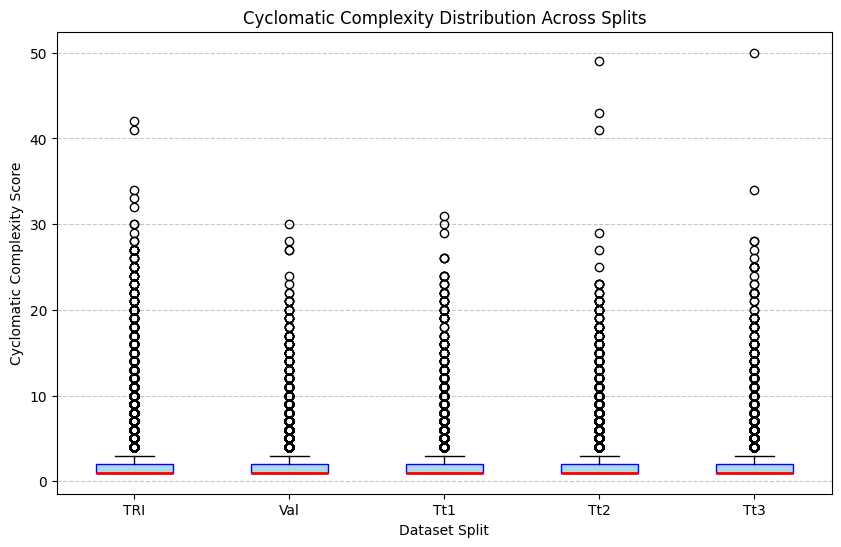

In [46]:
labels = list(complexity_data.keys())
data = list(complexity_data.values())

plt.figure(figsize=(10, 6))

plt.boxplot(data, labels=labels, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red', linewidth=2))

plt.title('Cyclomatic Complexity Distribution Across Splits')
plt.ylabel('Cyclomatic Complexity Score')
plt.xlabel('Dataset Split')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

## Question to Answer:
Do you see differences between Test Set 1, 2, and 3 in terms of cyclomatic complexity distribution? What might explain those differences?

There is quite a noticable difference when comparing the extremes from the different test sets. We can see that test set 1 has the fewest complex method outliers compared to the other sets. Test set 3 has the most complex functions. Because the test sets were split by the number of stars, my assumption is that test set 1 will have the best code quality compared to the later sets. A lot of the time a more complex function can be a marker for worse code quality. 

---
## Summary Statistics

In [49]:
import statistics

all_token_counts = [m['token_count'] for m in tokenized_methods]

print("=" * 50)
print("         DATASET CREATION SUMMARY")
print("=" * 50)

print(f"\nRepositories:")
print(f"   Cloned:    {len(cloned_repos)}")
print(f"   Failed:    {len(failed_repos)}")

print(f"\nJava Files:")
print(f"   Selected:  {len(all_selected_files)}")

print(f"\nMethods:")
print(f"   Extracted: {stats['total']}")
print(f"   Filtered:  {stats['total'] - stats['kept']} removed")
print(f"   Final:     {len(tokenized_methods)}")

print(f"\nToken Statistics:")
print(f"   Min:    {min(all_token_counts)}")
print(f"   Max:    {max(all_token_counts)}")
print(f"   Mean:   {statistics.mean(all_token_counts):.1f}")
print(f"   Median: {statistics.median(all_token_counts):.1f}")

print(f"\nDataset Splits:")
print(f"   Train:      {len(train_data):,} methods")
print(f"   Validation: {len(val_data):,} methods")
print(f"   Test1:       {len(test1_data):,} methods")
print(f"   Test2:       {len(test2_data):,} methods")
print(f"   Test3:       {len(test3_data):,} methods")

print(f"\nOutput Files:")
print(f"   {OUTPUT_DIR}/train.txt")
print(f"   {OUTPUT_DIR}/val.txt")
print(f"   {OUTPUT_DIR}/test1.txt")
print(f"   {OUTPUT_DIR}/test2.txt")
print(f"   {OUTPUT_DIR}/test3.txt")
print(f"   {OUTPUT_DIR}/metadata.json")

print("\n" + "=" * 50)
print("         DATASET READY FOR N-GRAM TRAINING")
print("=" * 50)

         DATASET CREATION SUMMARY

Repositories:
   Cloned:    698
   Failed:    2

Java Files:
   Selected:  12218

Methods:
   Extracted: 103230
   Filtered:  10977 removed
   Final:     80567

Token Statistics:
   Min:    10
   Max:    512
   Mean:   52.5
   Median: 29.0

Dataset Splits:
   Train:      33,066 methods
   Validation: 10,732 methods
   Test1:       12,892 methods
   Test2:       12,968 methods
   Test3:       10,909 methods

Output Files:
   dataset/ngram_dataset/train.txt
   dataset/ngram_dataset/val.txt
   dataset/ngram_dataset/test1.txt
   dataset/ngram_dataset/test2.txt
   dataset/ngram_dataset/test3.txt
   dataset/ngram_dataset/metadata.json

         DATASET READY FOR N-GRAM TRAINING


## ABOVE IS A DUPLICATE OF MY MINILAB 1 THAT I PRESENTED IN CLASS. I WILL NOW BEGIN BY MODIFYING THE RESULTING MINILAB 1 DATA FOR ASSIGNMENT 1.

In [ ]:
# Install nltk since I will be using their n-gram implementation
!pip install nltk


[notice] A new release of pip is available: 25.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [27]:
import os
import random
import json
import math
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import Lidstone # Also tested Laplace which is Lidstone with gamma = 1
from nltk.util import ngrams
from nltk.lm.vocabulary import Vocabulary

# Relative paths for data storage
DATA_DIR = "dataset/ngram_dataset/"
FILES = ["train.txt", "val.txt", "test1.txt", "test2.txt", "test3.txt"]
PROVIDED_TEST_FILE = os.path.join(DATA_DIR, "provided_test.txt")

N_VALUES = [3, 5, 7]
GAMMA = 0.01 # Lidstone smoothing parameter
UNK_LIMIT = 3 # Group tokens seen 3 or more times as <UNK>

# Random seed for reproducibility
random.seed(42)

In [28]:
# Helper function to load all data from files generated from minilab 1
def load_all_data(directory, file_list):
    all_methods = []
    for f_name in file_list:
        path = os.path.join(directory, f_name)
        if os.path.exists(path):
            with open(path, 'r', encoding='utf-8') as f:
                all_methods.extend([line.strip().split() for line in f if line.strip()])
    return all_methods

# Helper function to load the provided test set
def load_provided_test(file_path):
    if os.path.exists(file_path):
        with open(file_path, 'r', encoding='utf-8') as f:
            return [line.strip().split() for line in f if line.strip()]
    return []

provided_test_set = load_provided_test(PROVIDED_TEST_FILE)
print(f"Loaded Provided Test Set: {len(provided_test_set)} methods")

# Pool and shuffle for randomness
pool = load_all_data(DATA_DIR, FILES)
random.shuffle(pool)

# Reserve Validation and Test sets (1,000 methods each)
val_set = pool[:1000]
self_test_set = pool[1000:2000]

# Define training sets capped at specified sizes
remaining = pool[2000:]
train_sets = {
    "T1": remaining[:15000],
    "T2": remaining[:25000],
    "T3": remaining[:35000]
}

print(f"Pool: {len(pool)} | Val: {len(val_set)} | Test: {len(self_test_set)}")

Loaded Provided Test Set: 1000 methods
Pool: 80567 | Val: 1000 | Test: 1000


In [29]:
def train_ngram_model(train_data, n, gamma=GAMMA, cutoff=UNK_LIMIT):
    # Build vocabulary from scratch using only this training
    all_tokens = [t for method in train_data for t in method]
    vocab = Vocabulary(all_tokens, unk_cutoff=cutoff)
    
    # Initialize Lidstone model
    model = Lidstone(order=n, gamma=gamma, vocabulary=vocab)
    
    # Preprocess with <s> and </s> padding
    train_gen, _ = padded_everygram_pipeline(n, train_data)
    
    model.fit(train_gen)
    return model

In [30]:
def get_perplexity(model, test_data):
    test_ngrams = []
    for method in test_data:
        # Map tokens to <UNK> based on training vocab
        processed = list(model.vocab.lookup(method))
        
        # Generate n-grams matching the model's order
        method_ngrams = ngrams(processed, model.order, 
                               pad_left=True, left_pad_symbol="<s>",
                               pad_right=True, right_pad_symbol="</s>")
        test_ngrams.extend(method_ngrams)
    
    return model.perplexity(test_ngrams)

def get_predictions_for_method(model, tokens):
    results = []
    n = model.order
    safe_tokens = list(model.vocab.lookup(tokens))
    padded = ["<s>"] * (n - 1) + safe_tokens
    
    for i in range(n - 1, len(padded)):
        context = tuple(padded[i - (n - 1) : i])
        
        # Predict token that maximizes P(t_n | context)
        best_token = model.generate(1, text_seed=context)
        pred_prob = model.score(best_token, context)
        
        # Ground truth is the actual token provided in the method
        ground_truth = padded[i]
        
        results.append({
            "context": list(context),
            "predToken": best_token,
            "predProbability": round(pred_prob, 4),
            "groundTruth": ground_truth
        })
    return results

In [31]:
best_perp = float('inf')
best_model = None
best_config = {}

# Traing and calculate perplexity for all 9 n-gram models (3 training sets and 3 different n values)
for set_name, data in train_sets.items():
    for n in N_VALUES:
        print(f"Testing {n}-gram on {set_name}...")
        model = train_ngram_model(data, n)
        perp = get_perplexity(model, val_set)
        print(f"-> Result: Perp = {perp:.2f}")
        
        if perp < best_perp:
            best_perp = perp
            best_model = model
            best_config = {"n": n, "set": set_name}

print(f"\nFinal Selection: {best_config['set']} with n={best_config['n']} (Perp: {best_perp:.2f})")

Testing 3-gram on T1...
-> Result: Perp = 39.78
Testing 5-gram on T1...
-> Result: Perp = 213.76
Testing 7-gram on T1...
-> Result: Perp = 837.97
Testing 3-gram on T2...
-> Result: Perp = 47.93
Testing 5-gram on T2...
-> Result: Perp = 275.62
Testing 7-gram on T2...
-> Result: Perp = 1090.87
Testing 3-gram on T3...
-> Result: Perp = 54.30
Testing 5-gram on T3...
-> Result: Perp = 320.25
Testing 7-gram on T3...
-> Result: Perp = 1273.79

Final Selection: T1 with n=3 (Perp: 39.78)


In [32]:
def generate_output_json(model, test_data, filename, test_set_label):
    # Overall perplexity for the entire test set
    total_perp = get_perplexity(model, test_data)
    
    results = {
        "testSet": test_set_label,
        "perplexity": round(total_perp, 2),
        "data": []
    }
    
    for i, method_tokens in enumerate(test_data):
        method_id = f"ID{i+1}"
        # Extract predictions for each token in the method
        predictions = get_predictions_for_method(model, method_tokens)
        
        method_entry = {
            "index": method_id,
            "tokenizedCode": " ".join(method_tokens),
            "contextWindow": model.order,
            "predictions": predictions
        }
        results["data"].append(method_entry)
        
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=4)
    
    print(f"File generated: {filename}")

# Load the provided test set
PROVIDED_TEST_FILE = os.path.join(DATA_DIR, "provided_test.txt")
provided_test_data = []
if os.path.exists(PROVIDED_TEST_FILE):
    with open(PROVIDED_TEST_FILE, 'r', encoding='utf-8') as f:
        provided_test_data = [line.strip().split() for line in f if line.strip()]

In [33]:
# Generate results for the best model on the provided test set
generate_output_json(
    best_model, 
    provided_test_data, 
    "results-xxxxxx.json", 
    "provided_test.txt"
)

# Generate results for the best model on the self made test set
generate_output_json(
    best_model, 
    self_test_set, 
    "results-yyyyyy.json", 
    "test.txt"
)

print("\n--- Both output files have been generated. ---")

File generated: results-xxxxxx.json
File generated: results-yyyyyy.json

--- Both output files have been generated. ---
